In [1]:
## This notebook describes how to study 
## differential pointing between two pixel-pair bolometers

In [2]:
## Include the path to the package
import sys
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

## Import modules and routines
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware
from s4cmb.instrument import construct_beammap

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import modify_beam_offsets

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np
from copy import deepcopy

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
#########################################################################
## START OF THE SIMULATION
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> 
##   inject differential pointing -> MAP2TOD -> TOD2MAP
#########################################################################

In [4]:
## Initialise our input maps 
## (for test purposes, we create the maps on-the-fly from a CAMB file)
## Note that HealpixFitsMap can take as input a fits file with sky maps already in.
## Note also that for test purposes we use nside=2048 which is not so great for 
## studying differential pointing (effect O(10 arcsecond)). If you plan to study it
## properly, choose at least nside_in = 8192. (nside_out can be anything of course!).
sky_in = HealpixFitsMap('../s4cmb/data/test_data_set_lensedCls.dat', do_pol=True, 
                        fwhm_in=3.5, nside_in=2048, map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

In [5]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

In [6]:
## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will perform 1 deep scan (CES) of roughly 4h.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 8 Hz, and we will 
## scan the sky at a speed of 0.4 deg/s.
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../s4cmb/data/ut1utc.ephem', language='fortran')
scan.run()

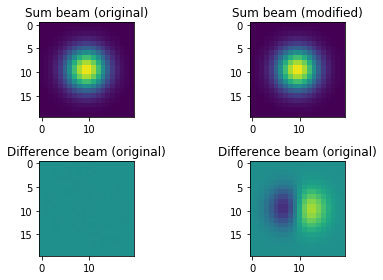

In [7]:
## Let's inject differential pointing between 
## two pixel-pair bolometers in our data!
## The model is the following:
## * Move randomly the position of the top bolometers only
##      within 10% of the beam scale (typical boresight pointing error).
## * Draw from a normal distribution G(mu, sigma) the magnitudes of the differential pointing rho.
## * Draw from a uniform distribution U(0, 2pi) the directions of the differential pointing theta.
## * Move the position of bottom bolometers as
##      - x_bottom = x_top + rho * cos(theta)
##      - y_bottom = x_top + rho * sin(theta)
## et voilà!

## For visualisation purposes, we will return a new array of modified timestream 
## (in practice, you probably want to overwrite the original array to save memory).
inst_mod = deepcopy(inst)

## Inject 10 arcsecond differential pointing (sigma = 5 arcsecond)
inst_mod.beam_model.xpos, inst_mod.beam_model.ypos = \
    modify_beam_offsets(inst_mod.beam_model.xpos, 
                        inst_mod.beam_model.ypos, 
                        inst_mod.beam_model.fwhm,
                        mu_diffpointing=10., 
                        sigma_diffpointing=5., 
                        seed=5847)

## Let's have a look at our beam parameters now
## Let's plot the resulting beam map for a pixel in the focal plane
summap_original, diffmap_original = construct_beammap(
    inst.beam_model, 0, 1, 20, 0.5 / 180. * np.pi / 60.)
summap_modified, diffmap_modified = construct_beammap(
    inst_mod.beam_model, 0, 1, 20, 0.5 / 180. * np.pi / 60.)
fig, ax = pl.subplots(2,2)
ax[0, 0].imshow(summap_original, vmin=0, vmax=1)
ax[0, 0].set_title('Sum beam (original)')
ax[0, 1].imshow(summap_modified, vmin=0, vmax=1)
ax[0, 1].set_title('Sum beam (modified)')

ax[1, 0].imshow(diffmap_original, vmin=-0.04, vmax=0.04)
ax[1, 0].set_title('Difference beam (original)')
ax[1, 1].imshow(diffmap_modified, vmin=-0.04, vmax=0.04)
ax[1, 1].set_title('Difference beam (original)')
pl.tight_layout()
pl.show()

100%|██████████| 128/128 [00:13<00:00,  8.48it/s]
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


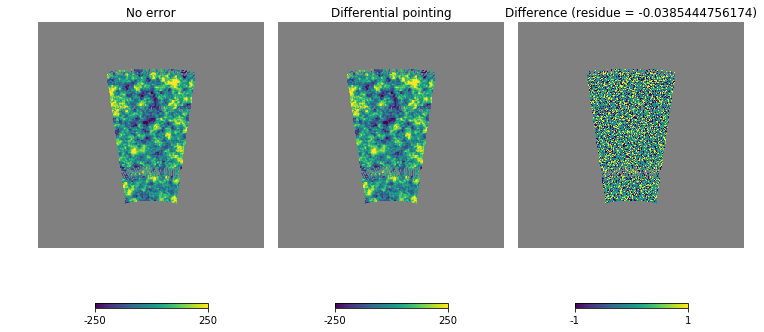

100%|██████████| 128/128 [00:06<00:00, 19.46it/s]


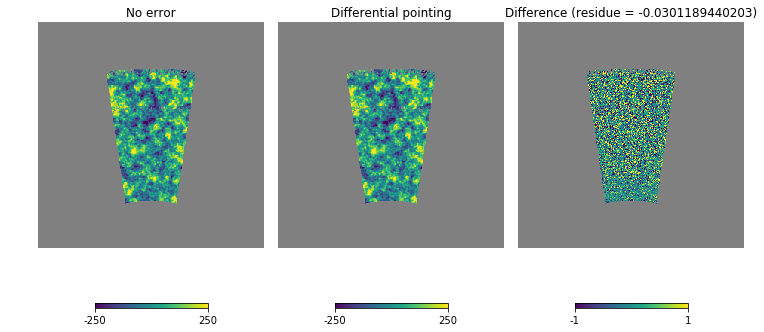

100%|██████████| 128/128 [00:06<00:00, 19.62it/s]


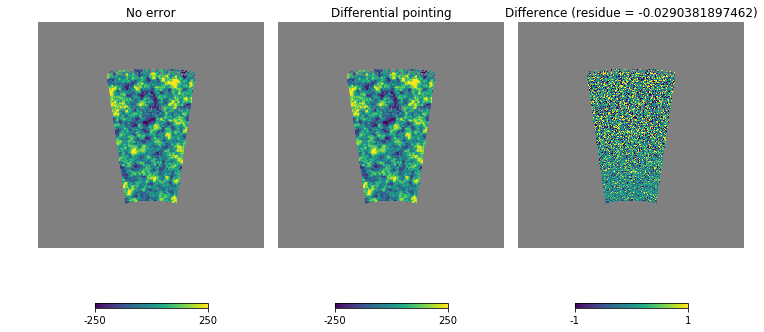

100%|██████████| 128/128 [00:06<00:00, 19.36it/s]


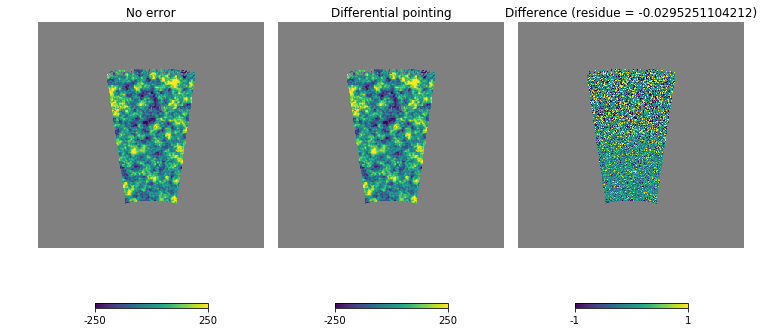

100%|██████████| 128/128 [00:08<00:00, 15.29it/s]


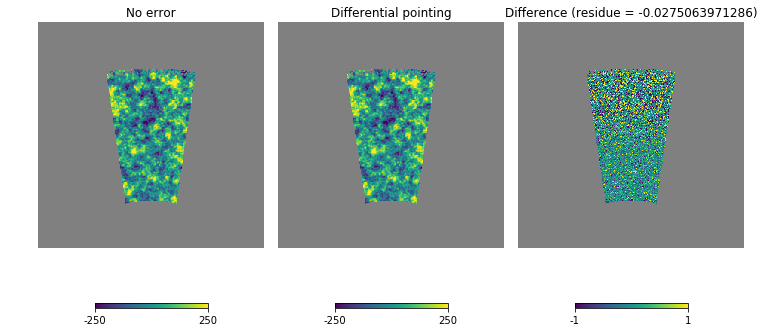

100%|██████████| 128/128 [00:09<00:00, 13.67it/s]


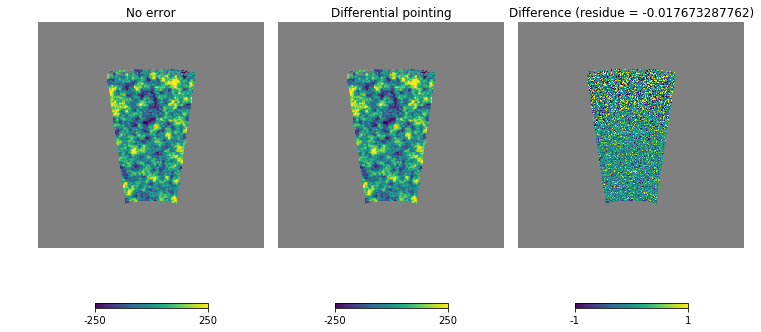

100%|██████████| 128/128 [00:09<00:00, 13.88it/s]


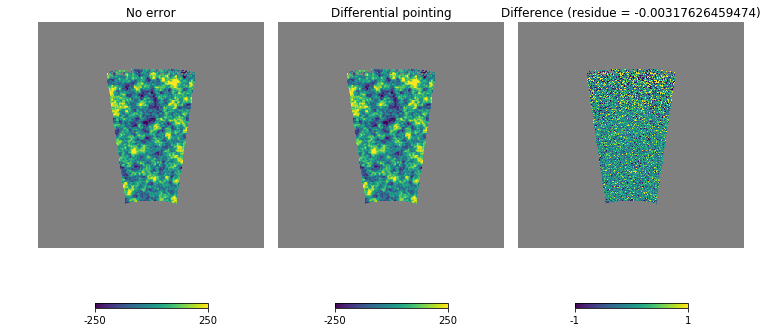

100%|██████████| 128/128 [00:06<00:00, 19.18it/s]


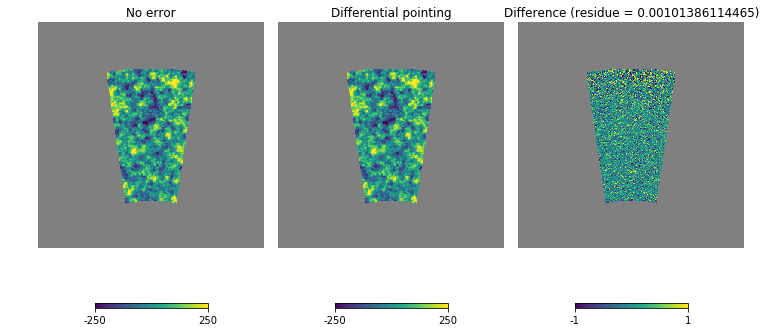

100%|██████████| 128/128 [00:05<00:00, 22.01it/s]


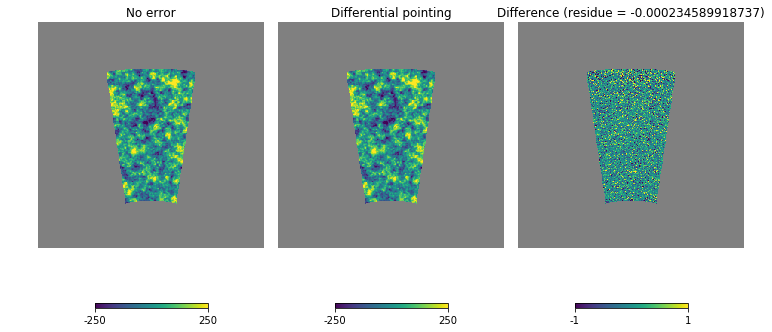

100%|██████████| 128/128 [00:05<00:00, 23.17it/s]


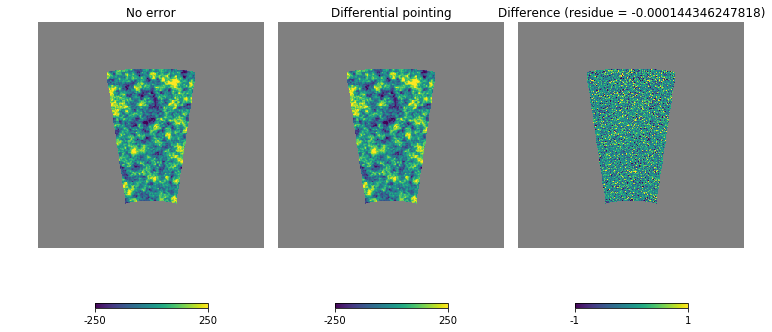

100%|██████████| 128/128 [00:04<00:00, 28.39it/s]


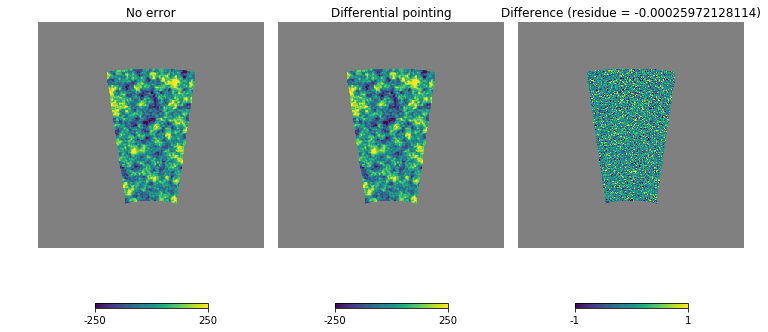

100%|██████████| 128/128 [00:15<00:00,  7.95it/s]


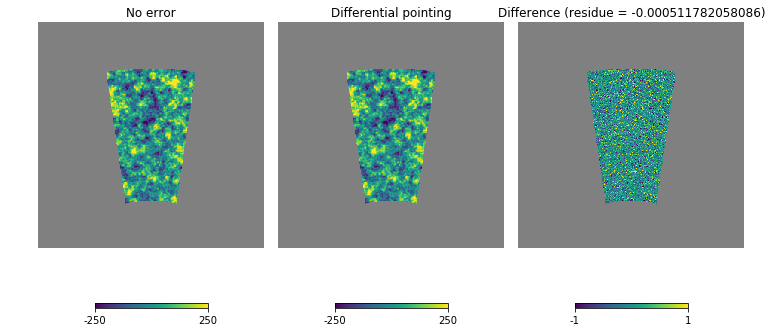

In [8]:
## Let's now generate our TOD from our input sky, instrument, and scanning strategy
## We will use the difference of pairs of detectors to reconstruct 
## the polarisation (no demodulation).
## Once we have the timestreams, we reconstruct the maps on a 
## sky patch of width 20 deg at a resolution nside = 2048.
nside_out = 2048
histograms = []
## Loop over CESs
for CESnumber in range(scan.nces):
    tod = TimeOrderedDataPairDiff(inst, scan, sky_in, CESnumber=CESnumber, 
                                  nside_out=nside_out, width=20.)
    tod_mod = TimeOrderedDataPairDiff(inst_mod, scan, sky_in, CESnumber=CESnumber, 
                                  nside_out=nside_out, width=20.)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot = OutputSkyMap(projection=tod.projection, 
                                   nside=nside_out, obspix=tod.obspix)
        sky_out_tot_mod = OutputSkyMap(projection=tod_mod.projection, 
                                       nside=nside_out, obspix=tod_mod.obspix)
        
    ## Scan input map to get TODs
    d = np.array([tod.map2tod(det) for det in tqdm(range(inst.focal_plane.nbolometer))])
    d_mod = np.array([tod_mod.map2tod(det) for det in tqdm(range(inst_mod.focal_plane.nbolometer))])
    
    ## Project TOD to maps
    tod.tod2map(d, sky_out_tot)
    tod_mod.tod2map(d_mod, sky_out_tot_mod)
    
    ## Plot temperature maps
    xsize = 300
    nhit = partial2full(sky_out_tot.nhit, sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
    fig = pl.figure(figsize=(10, 10))
    sky_out = partial2full(sky_out_tot.get_I(), sky_out_tot.obspix, 
                           sky_out_tot.nside, fill_with=0.0)
    sky_out_mod = partial2full(sky_out_tot_mod.get_I(), sky_out_tot_mod.obspix, 
                               sky_out_tot_mod.nside, fill_with=0.0)
    mask = nhit < 1
    sky_out[mask] = np.nan
    sky_out_mod[mask] = np.nan
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=131, 
                title='No error', notext=True, min=-250, max=250)
    hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=132, 
                title='Differential pointing', notext=True, min=-250, max=250)
    hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=133, 
                title='Difference (residue = {})'.format(
                    np.mean(sky_out_mod[~mask] - sky_out[~mask])), 
                notext=True, min=-1, max=1)
    pl.show()
    h, b, _ = pl.hist((sky_out_mod[~mask] - sky_out[~mask])/np.sqrt(nhit[~mask]), bins=50, 
                      histtype='step', lw=2, range=[-5, 5])
    histograms.append(h)
    pl.clf()

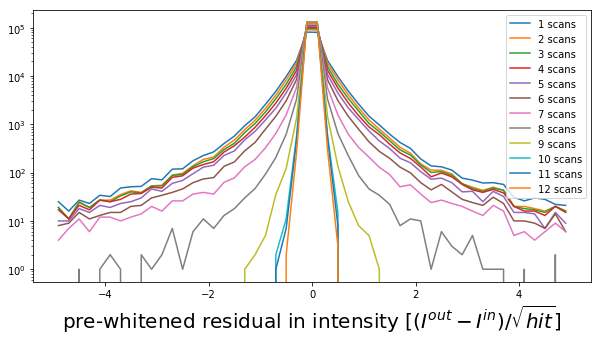

In [9]:
## Let's have a look at the pre-whitened residual in intensity, that is dI/sqrt(nhit).
## The residual decreases as we add more scans, i.e. the effect averages down.
fig = pl.figure(figsize=(10, 5))
for pos, h in enumerate(histograms):
    pl.plot(b[:-1] + np.diff(b)/2, h, label='{} scans'.format(pos + 1))
pl.legend()
pl.xlabel('pre-whitened residual in intensity [($I^{out} - I^{in} $)/$\sqrt{hit}$]', fontsize=20)
pl.yscale('log')
pl.show()

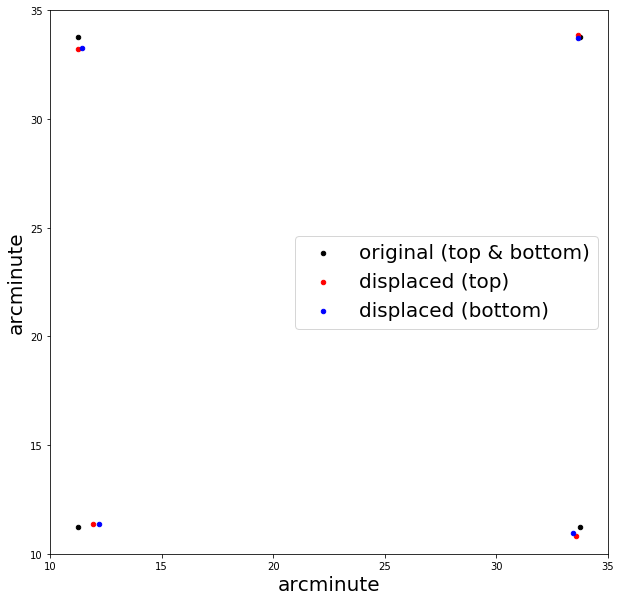

In [10]:
## Zoom on 4 pairs of bolometers in the focal plane
fig = pl.figure(figsize=(10, 10))
pl.scatter(inst.beam_model.xpos[::2]*180./np.pi*60,inst.beam_model.ypos[::2]*180./np.pi*60,
           c='black',alpha=1,s=20,marker='o',cmap=pl.cm.jet, label='original (top & bottom)')
pl.scatter(inst_mod.beam_model.xpos[::2]*180./np.pi*60,inst_mod.beam_model.ypos[::2]*180./np.pi*60,
           c='red',alpha=1,s=20,marker='o',cmap=pl.cm.jet, label='displaced (top)')
pl.scatter(inst_mod.beam_model.xpos[1::2]*180./np.pi*60,inst_mod.beam_model.ypos[1::2]*180./np.pi*60,
           c='blue',alpha=1,s=20,marker='o',cmap=pl.cm.jet, label='displaced (bottom)')
pl.xlim(10, 35)
pl.ylim(10, 35)
pl.xlabel('arcminute', fontsize=20)
pl.ylabel('arcminute', fontsize=20)
pl.legend(fontsize=20)
pl.show()

In [11]:
## Again, this example is not so realistic as one would need
## an input map with higher resolution (keep in mind we want to displace
## things by few arcseconds!). But the code would stay exactly the same in other circumstances!